# **Training The Model**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time, sys, os

import cv2
import opencv_transforms.transforms as OTT
import dataloader

import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.autograd import Variable

import models
import torchvision.models

import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    print("The gpu to be used : {}".format(torch.cuda.get_device_name(0)))
else:
    print("No gpu detected")

The gpu to be used : GeForce GTX 1660


# **Loading The Dataset**

In [2]:
with torch.no_grad():
    netC2S = models.Color2Sketch(pretrained=True).to(device)
    netC2S.eval()

Loading pretrained Color2Sketch model... Done!


In [3]:
# batch_size
batch_size = 2
numberofclust = 9

# Training data
transforms_the_training_dataset = OTT.Compose([
    OTT.RandomResizedCrop(256),
    OTT.RandomHorizontalFlip(),
    ])
open_traning_dataset = dataloader.Read_Dataset_Pair_images('/dataset/train', transforms_the_training_dataset, netC2S, numberofclust)
load_training_dataset = torch.utils.data.DataLoader(open_traning_dataset, batch_size=batch_size, shuffle=True)
print("The size of the training data is:{}".format(len(open_traning_dataset)))
bch_of_the_training = next(iter(load_training_dataset))


The size of the training data is:14224


## Viewing Dataset 



In [4]:
Iterationbatch= iter(load_training_dataset)

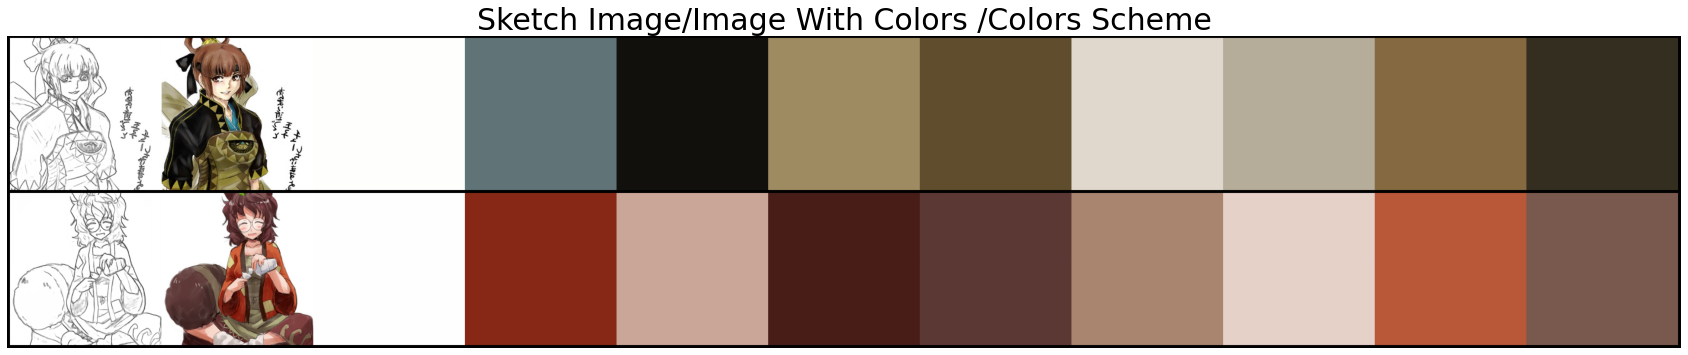

In [18]:
t_b = next(Iterationbatch)
e_img = t_b[0]
c_img = t_b[1]
list_of_c = t_b[2]

plt.figure(figsize=(30, 30))
result =torch.cat([e_img, c_img] + list_of_c,dim=-1)
plt.imshow(np.transpose(vutils.make_grid(result, nrow=1, padding=5, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Sketch Image/Image With Colors /Colors Scheme", fontsize=30)
plt.show()

# Construct the Model

In [19]:
nc = 3 * (numberofclust + 1)
network_of_skecth = models.Sketch2Color(nc=nc).to(device) 
network_disc = models.Discriminator(nc=nc+3).to(device)
netEx = torchvision.models.vgg16(True).features[0:4].to(device)

num_params = sum(p.numel() for p in network_of_skecth.parameters() if p.requires_grad) + sum(p.numel() for p in network_disc.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

torch.backends.cudnn.benchmark = True

Weights of Sketch2Color model are initialized
Weights of Discriminator model are initialized
Number of parameters: 66301674


# **Train the Model**

In [20]:
class Total_Variation_Loss(nn.Module):
    def __init__(self,Total_Variation_Loss_Weight=1.0):
        super(Total_Variation_Loss,self).__init__()
        self.Total_Variation_Loss_Weight = Total_Variation_Loss_Weight

    def forward(self, x):
        batch = x.size()[0]
        z = x.size()[2]
        q = x.size()[3]
        cz = self._tensor_size(x[:,:,1:,:])
        cq = self._tensor_size(x[:,:,:,1:])
        ztv = torch.pow((x[:,:,1:,:]-x[:,:,:z-1,:]),2).sum()
        qtv = torch.pow((x[:,:,:,1:]-x[:,:,:,:q-1]),2).sum()
        return self.Total_Variation_Loss_Weight*2*(ztv/cz+qtv/cq)/batch

    def _tensor_size(self,t):
        return t.size()[1]*t.size()[2]*t.size()[3]

In [21]:
Cur_eps=0
Num_eps = 25

lr = 2e-4

loss_GAN = torch.nn.MSELoss() 
Loss_L1 = torch.nn.L1Loss() 
Loss_L2 = torch.nn.MSELoss()
TVT = Total_Variation_Loss() 

lambda1 = 100
lambda2 = 1e-4
lambda3 = 1e-2

beta1 = 0.5
beta2 = 0.999

opt_skecth = torch.optim.Adam(network_of_skecth.parameters(),lr=lr, betas=(beta1, beta2))
opt_disc = torch.optim.Adam(network_disc.parameters(), lr=lr, betas=(beta2, beta2))

In [22]:
list_loss_disc = []
list_loss_skecth = []

In [ ]:
network_of_skecth.train()
network_disc.train()

start_epoch = Cur_eps
le = Num_eps + Cur_eps - 1
for epoch in range(Cur_eps, Num_eps + Cur_eps):
    Cur_eps += 1
       
    ST = time.time()
    TT = 0
    
    print('Epoch [{0}/{1}]'.format(epoch, le))
    for i, d in enumerate(load_training_dataset, 0):                  
            
        e = d[0].to(device)
        color = d[1].to(device)
        c_list = d[2]
        input_ten = torch.cat([e.cpu()] + c_list, dim=1).to(device)
        b_size = e.size(0)
        
        rlabel = Variable(torch.cuda.FloatTensor(b_size).fill_(0.9), requires_grad=False)
        flabel = Variable(torch.cuda.FloatTensor(b_size).fill_(0.0), requires_grad=False)
                             
        f = network_of_skecth(input_ten)
        pf = network_disc(input_ten, f)
        pr = network_disc(input_ten, color)
        

        opt_disc.zero_grad()
        
        loss_D_GAN = loss_GAN(pf, flabel) + loss_GAN(pr, rlabel)

        loss_D = 1.0 * loss_D_GAN
        loss_D.backward()

        opt_disc.step()

        f = network_of_skecth(input_ten)
        pf = network_disc(input_ten, f)
        pr = network_disc(input_ten, color)
        ff = netEx(f)
        rf = netEx(color)
        
        opt_skecth.zero_grad()
        
        loss_G_GAN = loss_GAN(pf, rlabel)
        
        loss_L1 = Loss_L1(f, color)
        
        loss_TV = TVT(f)
        
        loss_Feature = Loss_L2(ff, rf)
        
        loss_G = 1.0 * loss_G_GAN + lambda1 * loss_L1 + lambda2 * loss_TV + lambda3 * loss_Feature
        loss_G.backward()
        
        opt_skecth.step()

        if i%5 == 0:
            end_time = time.time()
            taken_time = end_time - ST
            TT += taken_time
            average_time = TT / (i+1) 

            print('\r[%d/%d] Loss D: %.2f / Loss_G: %.2f / Loss_G_GAN: %.2f / Loss_L1: %.2f /'\
                  ' Loss_TV: %.2f / Loss_Feature: %.2f / Time : %.2f (%.2f)'
                  % (i+1, len(load_training_dataset), loss_D.item(), loss_G.item(), loss_G_GAN.item(), 
                     loss_L1.item(), loss_TV, loss_Feature, taken_time, average_time), end='     ')
            ST = end_time
            
        if i%1000 == 0:
            print()            
        
        list_loss_disc.append(loss_D.cpu().item())
        list_loss_skecth.append(loss_G.cpu().item())
    print()
    
print('Done')

Epoch [0/24]
[1/7112] Loss D: 0.41 / Loss_G: 99.82 / Loss_G_GAN: 0.01 / Loss_L1: 1.00 / Loss_TV: 3.07 / Loss_Feature: 5.94 / Time : 6.05 (6.05)     
[101/7112] Loss D: 0.39 / Loss_G: 18.86 / Loss_G_GAN: 0.17 / Loss_L1: 0.19 / Loss_TV: 0.07 / Loss_Feature: 0.48 / Time : 3.35 (0.70)     